In [28]:
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model
from sklearn.ensemble import GradientBoostingClassifier
## for explainer
from lime import lime_tabular
from sklearn.utils import shuffle

In [29]:
df_data_without_scroll = pd.read_pickle('dataSessions.pkl')

In [30]:
df_data_without_scroll.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,674,6,6,0,7,7,0,45.545,736,393,0
1,129,6,6,0,6,6,0,54.128,572,360,0
2,474,6,6,0,7,7,0,18.090,775,412,0
3,741,6,6,0,7,7,0,27.660,827,412,0
4,208,6,6,0,6,6,0,36.191,765,412,0


In [31]:
for column in df_data_without_scroll:
    df_data_without_scroll[column] = df_data_without_scroll[column].astype(float)

In [32]:
'''
Recognize whether a column is numerical or categorical.
:parameter
    :param dtf: dataframe - input data
    :param col: str - name of the column to analyze
    :param max_cat: num - max number of unique values to recognize a column as categorical
:return
    "cat" if the column is categorical or "num" otherwise
'''
def utils_recognize_type(df_data_without_scroll, col, max_cat=20):
    if (df_data_without_scroll[col].dtype == "0") | (df_data_without_scroll[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

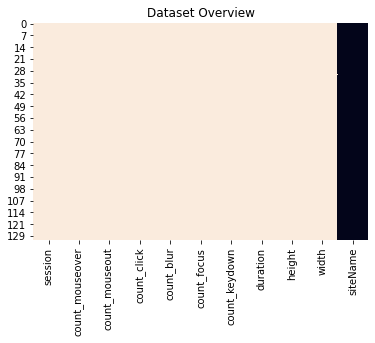

 Categerocial   Numeric   NaN 


In [33]:
dic_cols = {col:utils_recognize_type(df_data_without_scroll, col, max_cat=20) for col in df_data_without_scroll.columns}
heatmap = df_data_without_scroll.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [34]:
df_data_without_scroll = df_data_without_scroll.set_index("session")
df_data_without_scroll = df_data_without_scroll.rename(columns={"siteName":"Y"})

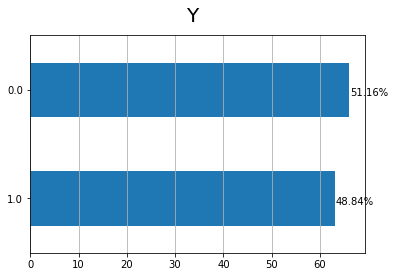

In [35]:
y = "Y"
ax = df_data_without_scroll[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


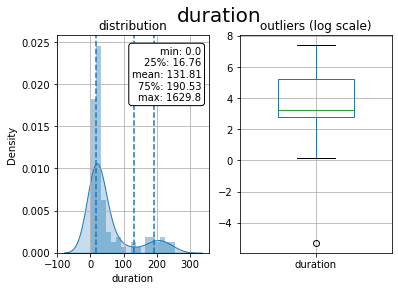

<Figure size 14400x7200 with 0 Axes>

In [40]:
x = "duration"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = df_data_without_scroll[x].fillna(df_data_without_scroll[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 13))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
plt.figure(figsize=(200,100))
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = df_data_without_scroll[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(df_data_without_scroll[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1], widths=(.5))
plt.show()

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3762: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarnin

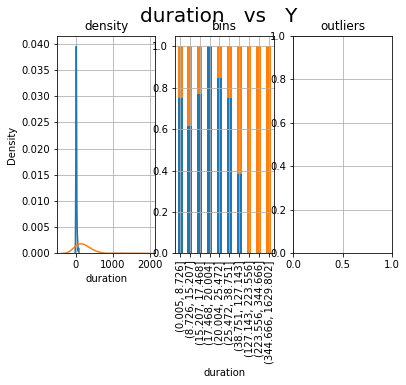

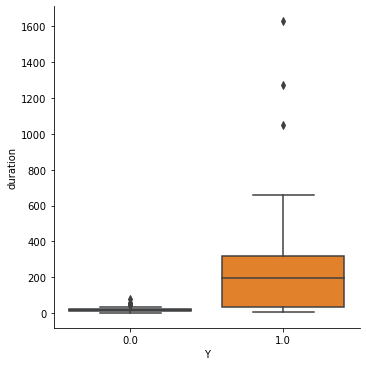

In [41]:
cat, num = "Y", "duration"
fig, ax = plt.subplots(nrows=1, ncols=3,  sharex=False, sharey=False)
fig.suptitle(x+"   vs   "+y, fontsize=20)
            
### distribution
ax[0].title.set_text('density')
for i in df_data_without_scroll[cat].unique():
    sns.distplot(df_data_without_scroll[df_data_without_scroll[cat]==i][num], hist=False, label=i, ax=ax[0])
ax[0].grid(True)
### stacked
ax[1].title.set_text('bins')
breaks = np.quantile(df_data_without_scroll[num], q=np.linspace(0,1,11))
tmp = df_data_without_scroll.groupby([cat, pd.cut(df_data_without_scroll[num], breaks, duplicates='drop')]).size().unstack().T
tmp = tmp[df_data_without_scroll[cat].unique()]
tmp["tot"] = tmp.sum(axis=1)
for col in tmp.drop("tot", axis=1).columns:
     tmp[col] = tmp[col] / tmp["tot"]
tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)
### boxplot   
ax[2].title.set_text('outliers')
sns.catplot(x=cat, y=num, data=df_data_without_scroll, kind="box", ax=ax[2])
ax[2].grid(True)
plt.show()

In [42]:
#wuhu split the data 
## split data
dtf_train, dtf_test = model_selection.train_test_split(df_data_without_scroll, 
                      test_size=0.3)
## print info
print("X_train shape:", dtf_train.drop("Y",axis=1).shape, "| X_test shape:", dtf_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dtf_train["Y"]),2), "| y_test mean:", round(np.mean(dtf_test["Y"]),2))
print(dtf_train.shape[1], "features:", dtf_train.drop("Y",axis=1).columns.to_list())

X_train shape: (90, 9) | X_test shape: (39, 9)
y_train mean: 0.54 | y_test mean: 0.36
10 features: ['count_mouseover', 'count_mouseout', 'count_click', 'count_blur', 'count_focus', 'count_keydown', 'duration', 'height', 'width']


In [ ]:
# ## create dummy --> ist für kategorisierete Daten da, allerdings brauchen wir die nicht weil wir keine Kategorien mehr haben 
# dummy = pd.get_dummies(dtf_train["type"], 
#                        prefix="type",drop_first=True)
# dtf_train= pd.concat([dtf_train, dummy], axis=1)
# ## drop the original categorical column
dtf = dtf_train.drop("type", axis=1)

# # ## create dummy
# # dummy2 = pd.get_dummies(dtf_train["elementId"], 
# #                        prefix="elementId",drop_first=True)
# # dtf_train= pd.concat([dtf_train, dummy2], axis=1)
# # ## drop the original categorical column
# # dtf = dtf_train.drop("elementId", axis=1)

In [43]:
dtf_train.head()

,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,Y
session,,,,,,,,,,
243.0,10.0,10.0,0.0,6.0,6.0,5.0,21.057,962.0,1724.0,0.0
247.0,2.0,2.0,0.0,6.0,6.0,3.0,17.226,1028.0,1728.0,0.0
852.0,2.0,1.0,0.0,3.0,2.0,0.0,83.281,635.0,375.0,1.0
440.0,6.0,6.0,0.0,6.0,6.0,7.0,17.532,663.0,390.0,0.0
883.0,6.0,6.0,0.0,6.0,6.0,4.0,19.673,669.0,390.0,0.0


In [44]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(dtf_train.drop("Y", axis=1))
dtf_scaled= pd.DataFrame(X, columns=dtf_train.drop("Y", axis=1).columns, index=dtf_train.index)
print(dtf_scaled)
dtf_scaled["Y"] = dtf_train["Y"]

         count_mouseover  count_mouseout  count_click  count_blur  \
session                                                             
243.0           0.035294        0.039062     0.000000    0.051282   
247.0           0.003922        0.007812     0.000000    0.051282   
852.0           0.003922        0.003906     0.000000    0.025641   
440.0           0.019608        0.023438     0.000000    0.051282   
883.0           0.019608        0.023438     0.000000    0.051282   
...                  ...             ...          ...         ...   
988.0           0.196078        0.199219     0.142857    0.119658   
951.0           0.062745        0.066406     0.015873    0.051282   
477.0           0.047059        0.050781     0.047619    0.136752   
232.0           0.011765        0.015625     0.000000    0.051282   
611.0           0.007843        0.011719     0.000000    0.051282   

         count_focus  count_keydown  duration    height     width  
session                           

In [45]:
from matplotlib.pyplot import figure
corr_matrix = dtf.copy()
for col in corr_matrix.columns:
    if corr_matrix[col].dtype == "O":
         corr_matrix[col] = corr_matrix[col].factorize(sort=True)[0]
corr_matrix = corr_matrix.corr(method="pearson")
fig, ax = plt.subplots(figsize=(20,10)) 
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=.5, ax=ax)
plt.title("pearson correlation")

NameError: name 'dtf' is not defined

In [46]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns
## Anova
selector = feature_selection.SelectKBest(score_func=  
               feature_selection.f_classif, k=10).fit(X,y)
anova_selected_features = feature_names[selector.get_support()]

## Lasso regularization
selector = feature_selection.SelectFromModel(estimator= 
              linear_model.LogisticRegression(C=1, penalty="l1", 
              solver='liblinear'), max_features=10).fit(X,y)
lasso_selected_features = feature_names[selector.get_support()]
 
## Plot
dtf_features = pd.DataFrame({"features":feature_names})
dtf_features["anova"] = dtf_features["features"].apply(lambda x: "anova" if x in anova_selected_features else "")
dtf_features["num1"] = dtf_features["features"].apply(lambda x: 1 if x in anova_selected_features else 0)
dtf_features["lasso"] = dtf_features["features"].apply(lambda x: "lasso" if x in lasso_selected_features else "")
dtf_features["num2"] = dtf_features["features"].apply(lambda x: 1 if x in lasso_selected_features else 0)
dtf_features["method"] = dtf_features[["anova","lasso"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dtf_features["selection"] = dtf_features["num1"] + dtf_features["num2"]
sns.barplot(y="features", x="selection", hue="method", data=dtf_features.sort_values("selection", ascending=False), dodge=False)

ValueError: k should be >=0, <= n_features = 9; got 10. Use k='all' to return all features.

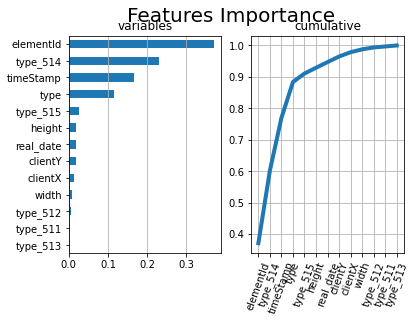

In [ ]:
X = dtf_train.drop("Y", axis=1).values
y = dtf_train["Y"].values
feature_names = dtf_train.drop("Y", axis=1).columns.tolist()
## Importance
model = ensemble.RandomForestClassifier(n_estimators=100,
                      criterion="entropy", random_state=0)
model.fit(X,y)
importances = model.feature_importances_
## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(
                kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [ ]:
dtf_train.head()


,elementId,timeStamp,type,Y,clientX,clientY,height,width,real_date,type_511,type_512,type_513,type_514,type_515
session,,,,,,,,,,,,,,
246,11,1625705.0,511,1,324.000000,324.000000,866.0,1439,1.722474,1,0,0,0,0
344,14,10618.8,513,1,614.857006,614.857006,878.0,1920,2.004719,0,0,1,0,0
241,12,171450.2,511,1,971.000000,971.000000,1237.0,2344,1.009670,1,0,0,0,0
431,19,31524.0,511,1,913.000000,913.000000,1312.0,1479,0.971848,1,0,0,0,0
857,15,77199.0,515,1,614.857006,614.857006,663.0,390,4.738321,0,0,0,0,1


In [ ]:
X_names = ['elementId', "type_514", "type", "timeStamp", "type_515", "real_date"]
# arr1 = dtf_train['elementId'].values
# arr3 = dtf_train['type'].values
# arr4 = dtf_train['timeStamp'].values
# arr6 = dtf_train['real_date'].values
# arr7 = dtf_train['type_511'].values
# arr8 = dtf_train['type_512'].values
# arr9 = dtf_train['type_513'].values
# arr10 = dtf_train['type_514'].values
# arr11 = dtf_train['type_515'].values
#X_train = [arr1, arr3, arr4, arr6, arr7, arr8, arr9, arr10]
X_train = dtf_train[X_names].values

arr1_ = dtf_test['elementId'].values
#arr2_ = dtf_test['type_514'].values
arr3_ = dtf_test['type'].values
arr4_ = dtf_test['timeStamp'].values
#arr5_ = dtf_test['type_515'].values
arr10_ = dtf_test['real_date'].values

#print(arr3)

#arr0 = np.array([np.arange(dtf_train[n].values) for n in range(len(X_names))])

# for item in (X_names):
#     X_train = np.array(dtf_train[item].values)
#     print(X_train)

y_train = dtf_train["Y"].values
X_test = [arr1_, arr3_, arr4_, arr10_]
y_test = dtf_test["Y"].values


In [ ]:
## call model
model = ensemble.GradientBoostingClassifier()
## define hyperparameters combinations to try
param_dic = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001],      #weighting factor for the corrections by new trees when added to the model
'n_estimators':[100,250,500,750,1000,1250,1500,1750],  #number of trees added to the model
'max_depth':[2,3,4,5,6,7],    #maximum depth of the tree
'min_samples_split':[2,4,6,8,10,20,40,60,100],    #sets the minimum number of samples to split
'min_samples_leaf':[1,3,5,7,9],     #the minimum number of samples to form a leaf
'max_features':[2,3,4,5,6,7],     #square root of features is usually a good starting point
'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]}       #the fraction of samples to be used for fitting the individual base learners. Values lower than 1 generally lead to a reduction of variance and an increase in bias.
## random search
random_search = model_selection.RandomizedSearchCV(model, 
       param_distributions=param_dic, n_iter=1000, 
       scoring="accuracy").fit(X_train, y_train)
print("Best Model parameters:", random_search.best_params_)
print("Best Model mean accuracy:", random_search.best_score_)
model = random_search.best_estimator_

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 498, in fit
    n_stages = self._fit_stages(
  File "/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 555, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py", line 211, in _fit_stage
    tree.fit(X, residual, sample_weight=sample_weight,
  File "/Users/ingaglotzbach/opt/anaconda3/lib/python3

KeyboardInterrupt: 